## This notebook presents the reproducible procedure that we followed in comparing the performance of Hybrid Quantum-Classical Neural Networks and Classical Convolutional Neural Networks on the GlaucomaFundus dataset. The GlaucomaFundus dataset is a glaucoma-focused dataset with 1544 fundus images. The dataset was produced in South Korea and is labeled with three-category classification (Non-Glaucoma, Early Glaucoma, and Glaucoma).

### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 26.3 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize
import random


os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Resnet-18-GLAUCOMAFUNDUS_models/"

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
import pickle

def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_loss = float('inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0
  early_stopping_patience = 10

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_without_improvement = 0  # Reset counter

      else:
            epochs_without_improvement += 1

      if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

  model.load_state_dict(best_model_weights)
  torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))

  metrics = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "train_aucs": train_aucs,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_aucs": val_aucs
    }

  with open(os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}_metrics.pkl'), 'wb') as f:
        pickle.dump(metrics, f)


  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
import math
import matplotlib.pyplot as plt

def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
    plt.style.use("default")

    loss_min = math.floor(min(min(quantum_loss), min(normal_loss)) * 10) / 10
    loss_max = math.ceil(max(max(quantum_loss), max(normal_loss)) * 10) / 10

    acc_min = math.floor(min(min(quantum_acc), min(normal_acc)) * 10) / 10
    acc_max = math.ceil(max(max(quantum_acc), max(normal_acc)) * 10) / 10

    auc_min = math.floor(min(min(quantum_auc), min(normal_auc)) * 10) / 10
    auc_max = math.ceil(max(max(quantum_auc), max(normal_auc)) * 10) / 10

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_loss, label="With quantum layer")
    plt.plot(normal_loss, label="Without quantum layer")
    plt.ylabel("Loss")
    plt.ylim([loss_min, loss_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_acc, label="With quantum layer")
    plt.plot(normal_acc, label="Without quantum layer")
    plt.ylabel("Accuracy")
    plt.ylim([acc_min, acc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Accuracy vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_auc, label="With quantum layer")
    plt.plot(normal_auc, label="Without quantum layer")
    plt.ylabel("ROCAUC")
    plt.ylim([auc_min, auc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("ROCAUC vs. Epoch")
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import label_binarize
from itertools import cycle


def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)


            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)
            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds_hybrid = np.array(all_preds_hybrid)
    all_preds_normal = np.array(all_preds_normal)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)


    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)


    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')


    if num_classes == 2:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, pos_label=1)
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, pos_label=1)
        precision_normal = precision_score(all_labels, all_preds_normal, pos_label=1)
        recall_normal = recall_score(all_labels, all_preds_normal, pos_label=1)
    else:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, average='weighted')
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, average='weighted')
        precision_normal = precision_score(all_labels, all_preds_normal, average='weighted')
        recall_normal = recall_score(all_labels, all_preds_normal, average='weighted')


    hybrid_aucs = []
    normal_aucs = []

    if num_classes == 2:

        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)

        print(f'Hybrid Model AUROC: {auc_hybrid:.4f}')
        print(f'Normal Model AUROC: {auc_normal:.4f}')

        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUROC = {auc_hybrid:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Hybrid Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curve for the Normal Model
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUROC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Normal Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

    else:  # Multi-class Classification

        all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))

        # Define a color cycle for plotting
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
        # Plot ROC curves for the Hybrid Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_hybrid[:, i])
            roc_auc = auc(fpr, tpr)
            hybrid_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Hybrid Model')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curves for the Normal Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_normal[:, i])
            roc_auc = auc(fpr, tpr)
            normal_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Normal Model')
        plt.legend(loc='lower right')
        plt.show()



    normal_auc = f"{sum(normal_aucs) / len(normal_aucs):.4f}"
    hybrid_auc = f"{sum(hybrid_aucs) / len(hybrid_aucs):.4f}"

    print("\nHybrid Model Metrics:")
    print(f'Accuracy: {accuracy_hybrid:.4f}')
    print(f'F1 Score: {f1_hybrid:.4f}')
    print(f'Precision: {precision_hybrid:.4f}')
    print(f'Recall: {recall_hybrid:.4f}')
    print(f'AUROC: {hybrid_auc}')

    print("\nNormal Model Metrics:")
    print(f'Accuracy: {accuracy_normal:.4f}')
    print(f'F1 Score: {f1_normal:.4f}')
    print(f'Precision: {precision_normal:.4f}')
    print(f'Recall: {recall_normal:.4f}')
    print(f'AUROC: {normal_auc} \n')

    cm_hybrid = confusion_matrix(all_labels, all_preds_hybrid)


    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: Hybrid Model (Avg AUC = {hybrid_auc})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    cm_normal = confusion_matrix(all_labels, all_preds_normal)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: Classical Model (Avg AUC = {normal_auc})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def load_data(batch_size, dataset):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

  return train_loader, valid_loader, test_loader

### Classical CNN Model Construction and General Methods

In [ ]:
class NormalModel(nn.Module):
  def __init__(self, freeze, num_classes, device='cuda'):
        super(NormalModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

### Hybrid Quantum-classical Neural Network Construction

In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
class DressedQuantumNet(nn.Module):

    def __init__(self, q_depth, num_classes):

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):


        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [ ]:
class QuantumHybridModel(nn.Module):
  def __init__(self, q_depth, freeze, num_classes, device='cuda'):
        super(QuantumHybridModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = DressedQuantumNet(q_depth, num_classes)

        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

# Experiments

In [ ]:
n_epochs = 100
num_classes = 3
batch_size = 32
dataset = "GlaucomaFundus"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
q_depth = 4

# Seed Experiment 1

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=3)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 80:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0101, Training Accuracy: 53.43%, Training AUROC: 0.5981
Validation Loss: 0.9860, Validation Accuracy: 55.50%, Validation AUROC: 0.6096
Epoch [2/100]
Training Loss: 0.9553, Training Accuracy: 56.91%, Training AUROC: 0.6555
Validation Loss: 0.9303, Validation Accuracy: 62.84%, Validation AUROC: 0.6850
Epoch [3/100]
Training Loss: 0.9031, Training Accuracy: 60.98%, Training AUROC: 0.7109
Validation Loss: 0.8642, Validation Accuracy: 66.97%, Validation AUROC: 0.7547
Epoch [4/100]
Training Loss: 0.8315, Training Accuracy: 65.51%, Training AUROC: 0.7815
Validation Loss: 0.8088, Validation Accuracy: 68.81%, Validation AUROC: 0.7974
Epoch [5/100]
Training Loss: 0.7829, Training Accuracy: 67.71%, Training AUROC: 0.8059
Validation Loss: 0.7593, Validation Accuracy: 67.89%, Validation AUROC: 0.8242
Epoch [6/100]
Training Loss: 0.7057, Training Accuracy: 72.47%, Training AUROC: 0.8510
Validation Loss: 0.7233, Validation Accuracy: 71.56%, Validation AUROC: 0.8423
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.1558, Training Accuracy: 29.38%, Training AUROC: 0.4784
Validation Loss: 1.1276, Validation Accuracy: 24.77%, Validation AUROC: 0.4626
Epoch [2/100]
Training Loss: 1.0506, Training Accuracy: 44.60%, Training AUROC: 0.5388
Validation Loss: 1.0266, Validation Accuracy: 50.92%, Validation AUROC: 0.5380
Epoch [3/100]
Training Loss: 0.9765, Training Accuracy: 52.38%, Training AUROC: 0.6878
Validation Loss: 1.0013, Validation Accuracy: 51.83%, Validation AUROC: 0.6120
Epoch [4/100]
Training Loss: 0.9380, Training Accuracy: 62.25%, Training AUROC: 0.7406
Validation Loss: 0.9632, Validation Accuracy: 58.72%, Validation AUROC: 0.6823
Epoch [5/100]
Training Loss: 0.8948, Training Accuracy: 67.83%, Training AUROC: 0.7834
Validation Loss: 0.9173, Validation Accuracy: 61.93%, Validation AUROC: 0.7403
Epoch [6/100]
Training Loss: 0.8467, Training Accuracy: 69.22%, Training AUROC: 0.8277
Validation Loss: 0.8841, Validation Accuracy: 64.68%, Validation AUROC: 0.7640
Epoc

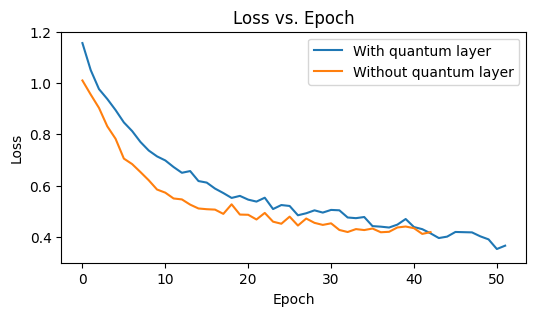

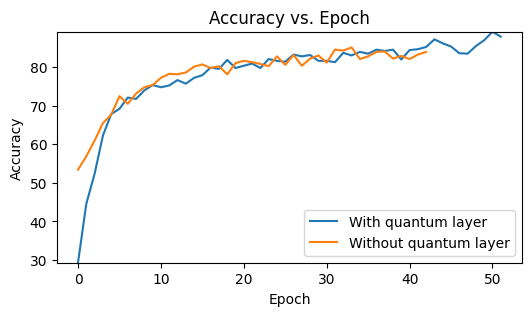

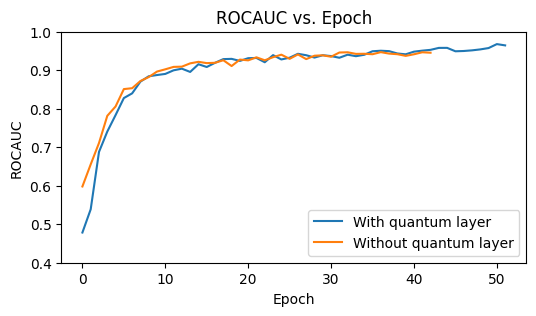

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

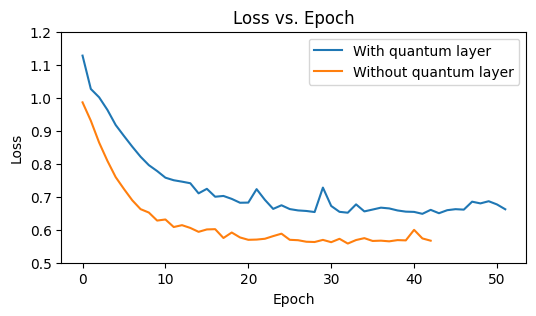

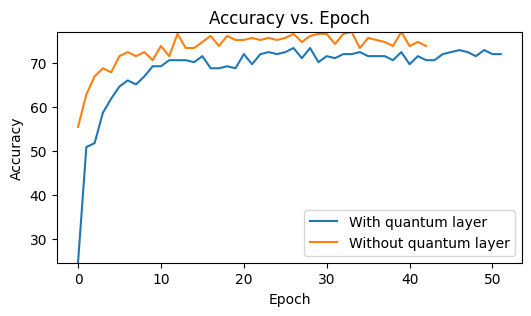

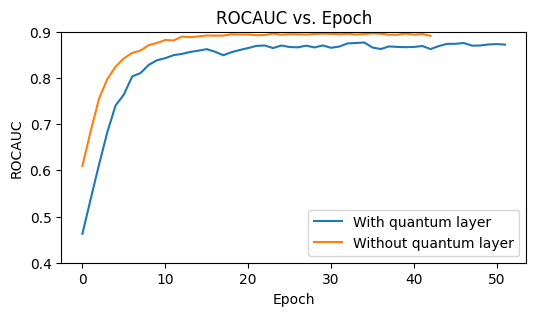

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

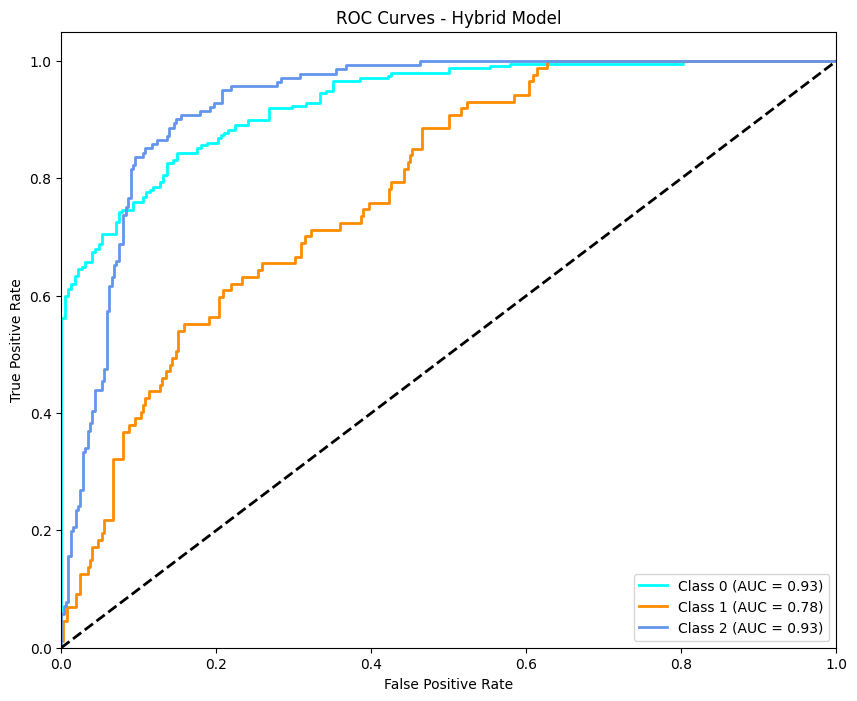

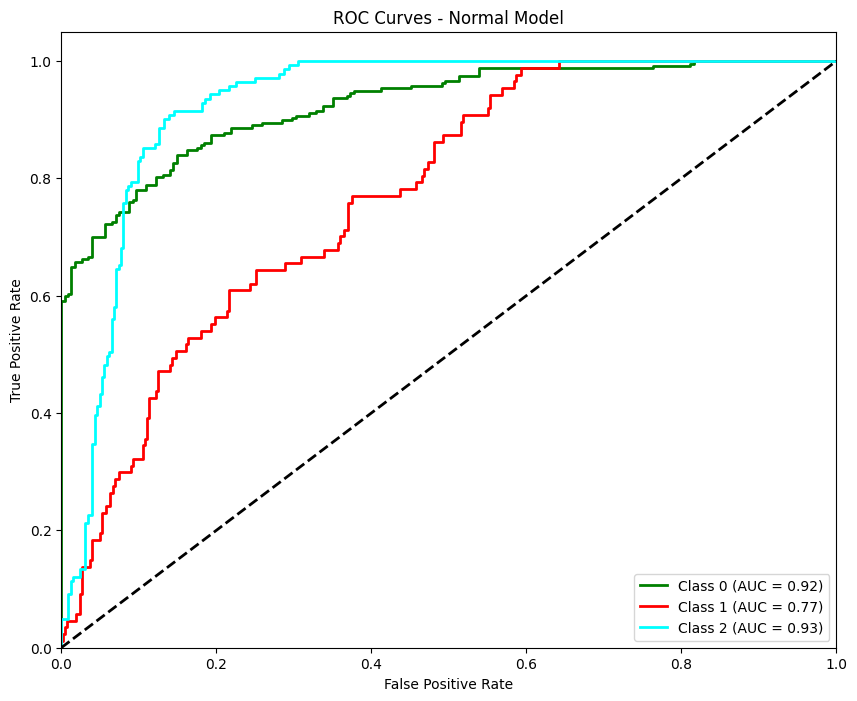


Hybrid Model Metrics:
Accuracy: 0.7527
F1 Score: 0.7470
Precision: 0.7466
Recall: 0.7527
AUROC: 0.8803

Normal Model Metrics:
Accuracy: 0.7505
F1 Score: 0.7402
Precision: 0.7345
Recall: 0.7505
AUROC: 0.8748 



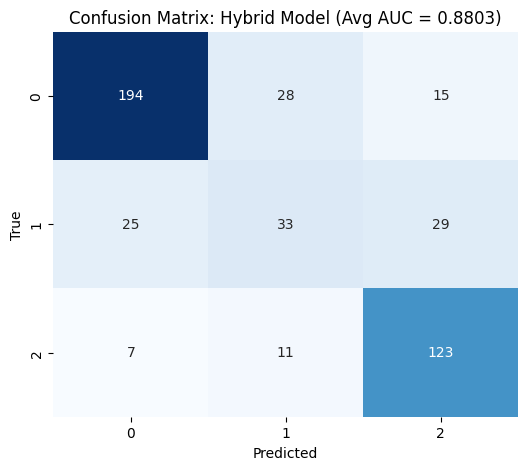

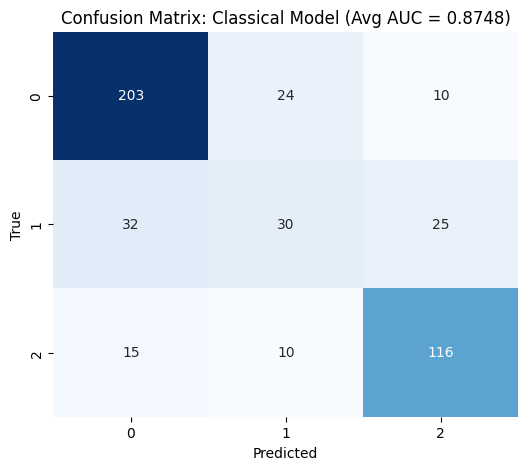

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

# Seed Experiment 2

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=3)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 35:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.1930, Training Accuracy: 30.78%, Training AUROC: 0.4818
Validation Loss: 1.0908, Validation Accuracy: 37.16%, Validation AUROC: 0.4923
Epoch [2/100]
Training Loss: 1.0439, Training Accuracy: 49.25%, Training AUROC: 0.5216
Validation Loss: 1.0289, Validation Accuracy: 51.38%, Validation AUROC: 0.5634
Epoch [3/100]
Training Loss: 0.9718, Training Accuracy: 54.36%, Training AUROC: 0.6243
Validation Loss: 0.9617, Validation Accuracy: 55.96%, Validation AUROC: 0.6524
Epoch [4/100]
Training Loss: 0.9014, Training Accuracy: 61.56%, Training AUROC: 0.7194
Validation Loss: 0.8971, Validation Accuracy: 57.34%, Validation AUROC: 0.7217
Epoch [5/100]
Training Loss: 0.8268, Training Accuracy: 64.46%, Training AUROC: 0.7854
Validation Loss: 0.8392, Validation Accuracy: 65.14%, Validation AUROC: 0.7663
Epoch [6/100]
Training Loss: 0.7687, Training Accuracy: 68.41%, Training AUROC: 0.8163
Validation Loss: 0.7911, Validation Accuracy: 65.14%, Validation AUROC: 0.7961
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0546, Training Accuracy: 43.55%, Training AUROC: 0.5621
Validation Loss: 1.0256, Validation Accuracy: 50.00%, Validation AUROC: 0.5838
Epoch [2/100]
Training Loss: 1.0048, Training Accuracy: 52.15%, Training AUROC: 0.5969
Validation Loss: 0.9885, Validation Accuracy: 54.59%, Validation AUROC: 0.6371
Epoch [3/100]
Training Loss: 0.9720, Training Accuracy: 55.28%, Training AUROC: 0.7018
Validation Loss: 0.9633, Validation Accuracy: 57.34%, Validation AUROC: 0.6965
Epoch [4/100]
Training Loss: 0.9335, Training Accuracy: 62.02%, Training AUROC: 0.7638
Validation Loss: 0.9351, Validation Accuracy: 63.30%, Validation AUROC: 0.7392
Epoch [5/100]
Training Loss: 0.9011, Training Accuracy: 65.62%, Training AUROC: 0.7891
Validation Loss: 0.9086, Validation Accuracy: 66.06%, Validation AUROC: 0.7675
Epoch [6/100]
Training Loss: 0.8799, Training Accuracy: 67.36%, Training AUROC: 0.7975
Validation Loss: 0.8805, Validation Accuracy: 67.43%, Validation AUROC: 0.7889
Epoc

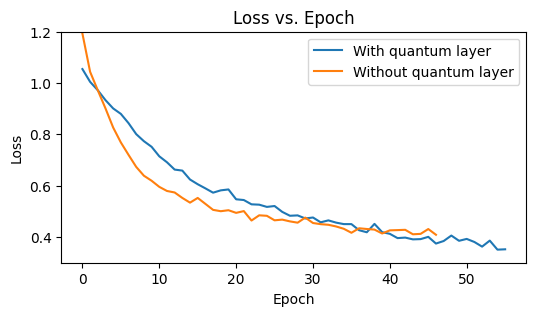

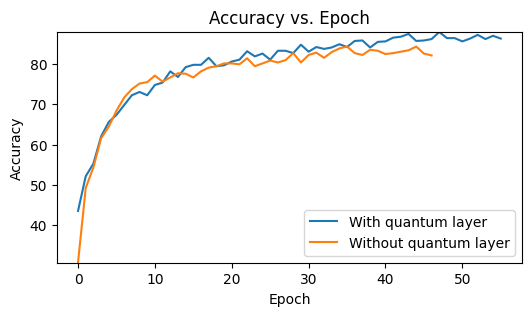

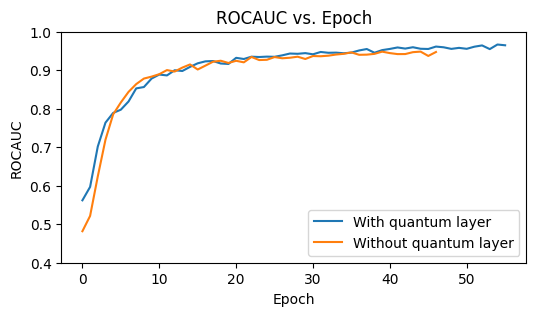

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

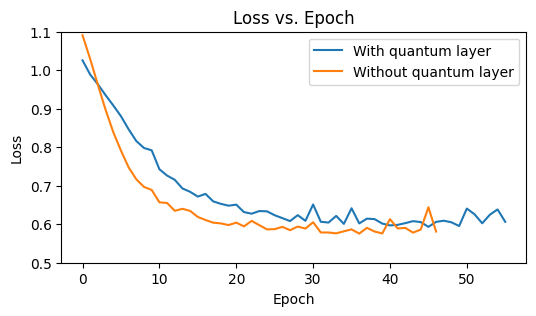

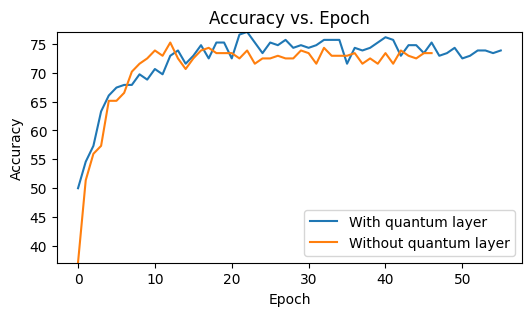

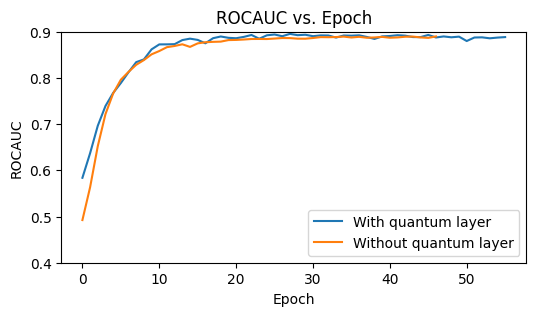

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

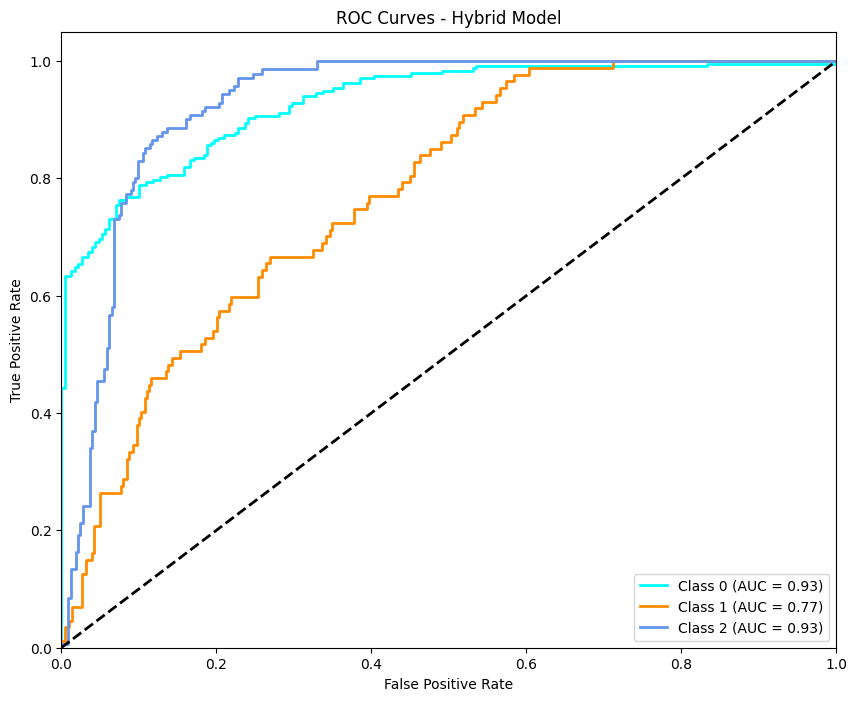

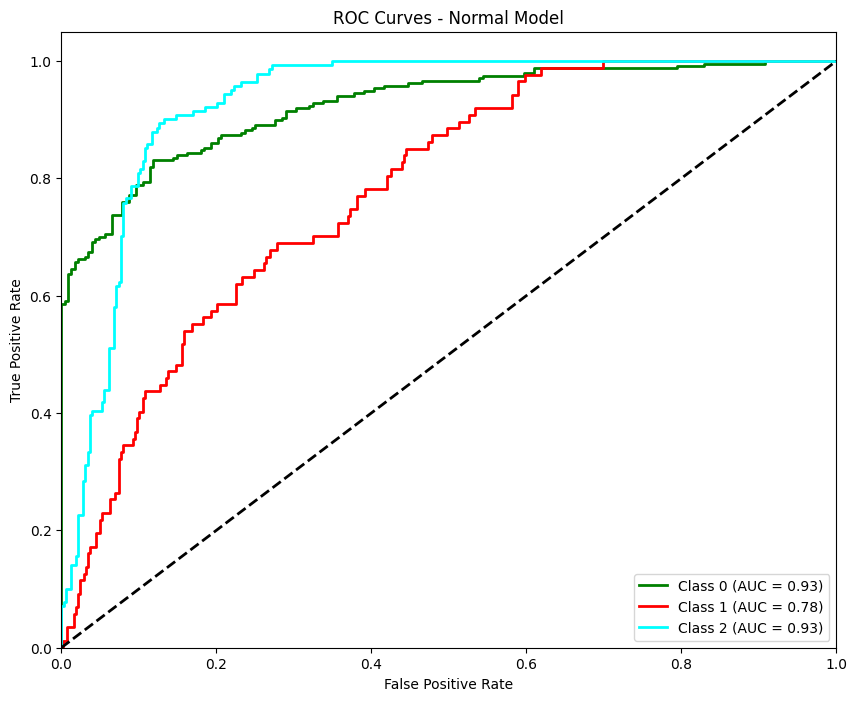


Hybrid Model Metrics:
Accuracy: 0.7484
F1 Score: 0.7342
Precision: 0.7307
Recall: 0.7484
AUROC: 0.8775

Normal Model Metrics:
Accuracy: 0.7634
F1 Score: 0.7637
Precision: 0.7684
Recall: 0.7634
AUROC: 0.8778 



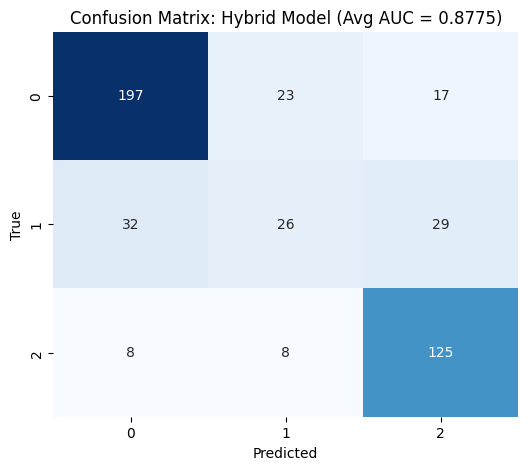

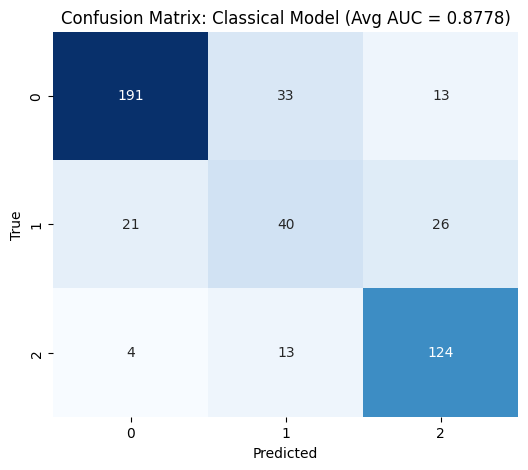

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

# Seed Experiment 3

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=3)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 71:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.1646, Training Accuracy: 33.45%, Training AUROC: 0.4681
Validation Loss: 1.0873, Validation Accuracy: 40.83%, Validation AUROC: 0.4778
Epoch [2/100]
Training Loss: 1.0469, Training Accuracy: 48.78%, Training AUROC: 0.5116
Validation Loss: 1.0353, Validation Accuracy: 52.75%, Validation AUROC: 0.5219
Epoch [3/100]
Training Loss: 0.9697, Training Accuracy: 56.21%, Training AUROC: 0.6292
Validation Loss: 0.9734, Validation Accuracy: 58.72%, Validation AUROC: 0.6070
Epoch [4/100]
Training Loss: 0.9056, Training Accuracy: 59.70%, Training AUROC: 0.7106
Validation Loss: 0.9051, Validation Accuracy: 60.55%, Validation AUROC: 0.6866
Epoch [5/100]
Training Loss: 0.8267, Training Accuracy: 63.41%, Training AUROC: 0.7800
Validation Loss: 0.8452, Validation Accuracy: 66.97%, Validation AUROC: 0.7410
Epoch [6/100]
Training Loss: 0.7614, Training Accuracy: 69.34%, Training AUROC: 0.8250
Validation Loss: 0.7990, Validation Accuracy: 65.14%, Validation AUROC: 0.7707
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.2560, Training Accuracy: 30.20%, Training AUROC: 0.5038
Validation Loss: 1.1469, Validation Accuracy: 33.03%, Validation AUROC: 0.5113
Epoch [2/100]
Training Loss: 1.0653, Training Accuracy: 46.81%, Training AUROC: 0.5193
Validation Loss: 1.0365, Validation Accuracy: 55.05%, Validation AUROC: 0.5628
Epoch [3/100]
Training Loss: 1.0232, Training Accuracy: 53.54%, Training AUROC: 0.5747
Validation Loss: 1.0075, Validation Accuracy: 55.50%, Validation AUROC: 0.6105
Epoch [4/100]
Training Loss: 0.9836, Training Accuracy: 59.58%, Training AUROC: 0.6462
Validation Loss: 0.9748, Validation Accuracy: 59.63%, Validation AUROC: 0.6698
Epoch [5/100]
Training Loss: 0.9585, Training Accuracy: 61.21%, Training AUROC: 0.6744
Validation Loss: 0.9409, Validation Accuracy: 63.76%, Validation AUROC: 0.7181
Epoch [6/100]
Training Loss: 0.9108, Training Accuracy: 66.32%, Training AUROC: 0.7353
Validation Loss: 0.9020, Validation Accuracy: 64.68%, Validation AUROC: 0.7510
Epoc

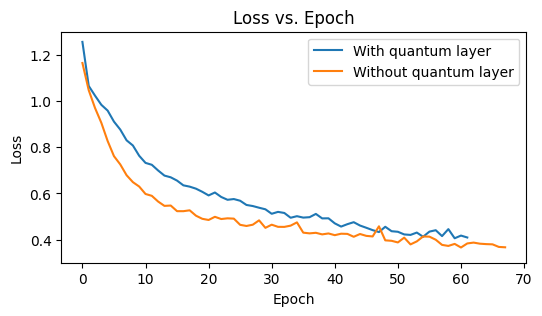

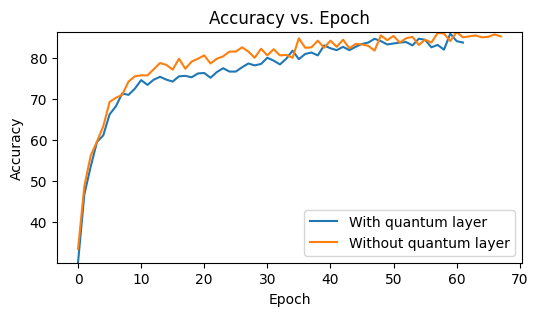

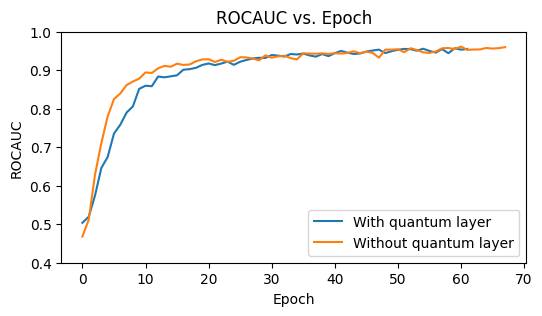

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

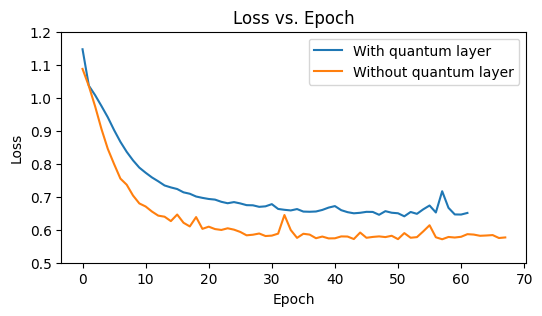

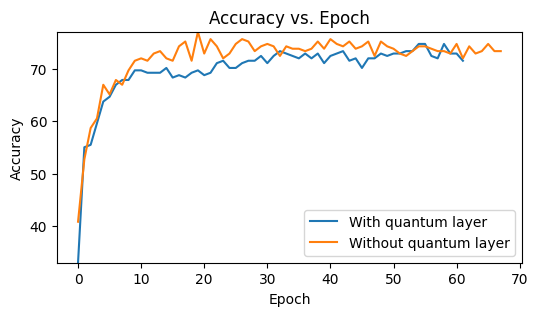

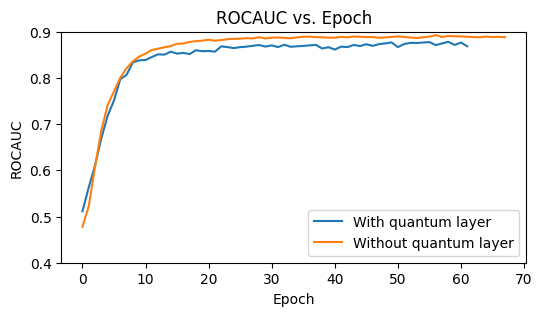

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

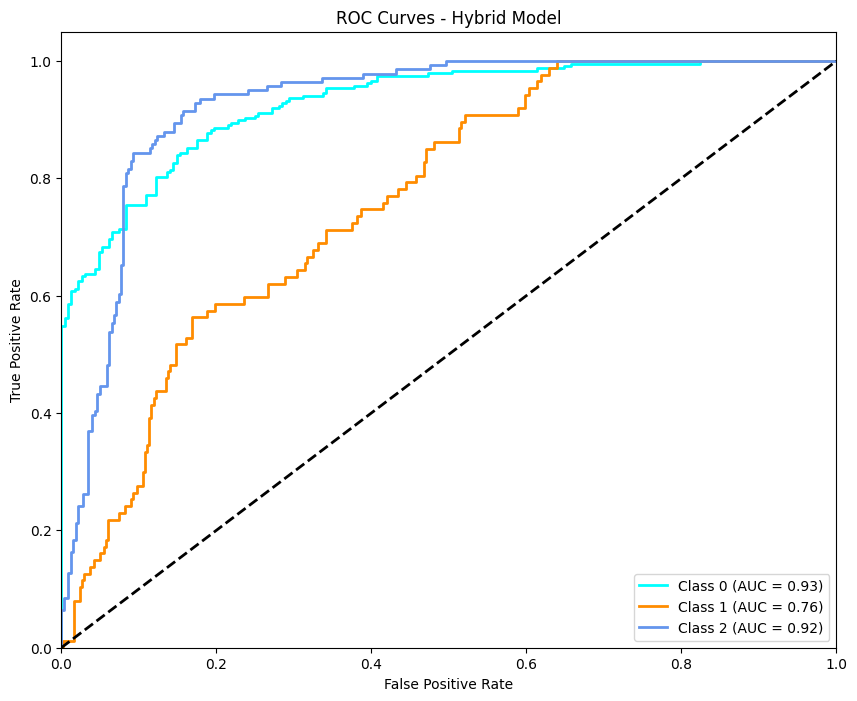

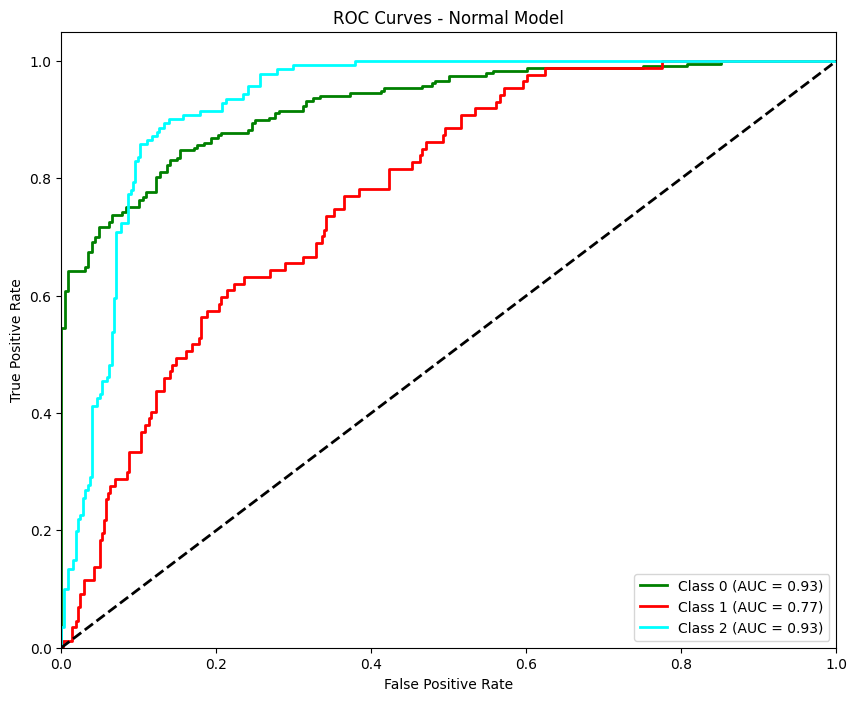


Hybrid Model Metrics:
Accuracy: 0.7462
F1 Score: 0.7321
Precision: 0.7240
Recall: 0.7462
AUROC: 0.8722

Normal Model Metrics:
Accuracy: 0.7656
F1 Score: 0.7599
Precision: 0.7568
Recall: 0.7656
AUROC: 0.8758 



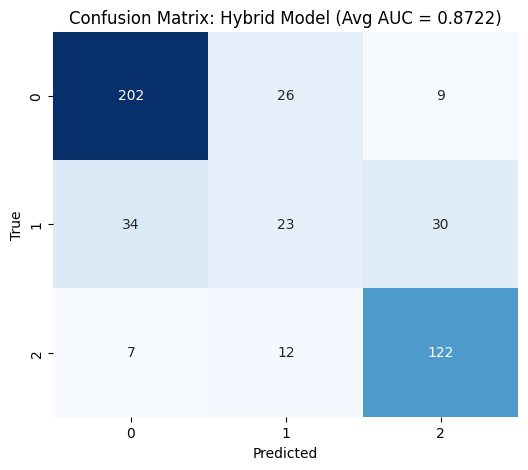

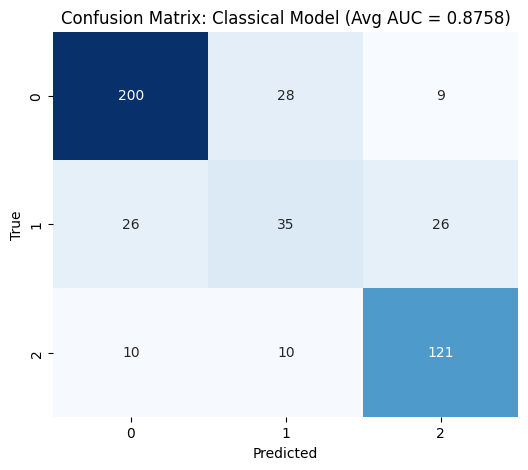

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

# Seed Experiment 4

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=3)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 42:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.2041, Training Accuracy: 31.94%, Training AUROC: 0.4123
Validation Loss: 1.0951, Validation Accuracy: 45.87%, Validation AUROC: 0.4874
Epoch [2/100]
Training Loss: 1.0854, Training Accuracy: 47.15%, Training AUROC: 0.4631
Validation Loss: 1.0363, Validation Accuracy: 48.62%, Validation AUROC: 0.5327
Epoch [3/100]
Training Loss: 1.0087, Training Accuracy: 52.38%, Training AUROC: 0.5837
Validation Loss: 0.9649, Validation Accuracy: 55.50%, Validation AUROC: 0.6481
Epoch [4/100]
Training Loss: 0.9213, Training Accuracy: 57.14%, Training AUROC: 0.7053
Validation Loss: 0.8902, Validation Accuracy: 61.93%, Validation AUROC: 0.7379
Epoch [5/100]
Training Loss: 0.8471, Training Accuracy: 62.72%, Training AUROC: 0.7713
Validation Loss: 0.8321, Validation Accuracy: 65.14%, Validation AUROC: 0.7814
Epoch [6/100]
Training Loss: 0.7762, Training Accuracy: 67.25%, Training AUROC: 0.8129
Validation Loss: 0.7768, Validation Accuracy: 69.27%, Validation AUROC: 0.8076
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0969, Training Accuracy: 36.70%, Training AUROC: 0.5066
Validation Loss: 1.0163, Validation Accuracy: 48.17%, Validation AUROC: 0.5755
Epoch [2/100]
Training Loss: 1.0155, Training Accuracy: 50.17%, Training AUROC: 0.5555
Validation Loss: 0.9756, Validation Accuracy: 55.96%, Validation AUROC: 0.6257
Epoch [3/100]
Training Loss: 0.9576, Training Accuracy: 57.38%, Training AUROC: 0.6557
Validation Loss: 0.9103, Validation Accuracy: 62.39%, Validation AUROC: 0.7186
Epoch [4/100]
Training Loss: 0.8833, Training Accuracy: 62.14%, Training AUROC: 0.7601
Validation Loss: 0.8508, Validation Accuracy: 66.97%, Validation AUROC: 0.7787
Epoch [5/100]
Training Loss: 0.8113, Training Accuracy: 68.52%, Training AUROC: 0.8221
Validation Loss: 0.8003, Validation Accuracy: 69.72%, Validation AUROC: 0.8221
Epoch [6/100]
Training Loss: 0.7780, Training Accuracy: 70.03%, Training AUROC: 0.8351
Validation Loss: 0.7648, Validation Accuracy: 71.56%, Validation AUROC: 0.8438
Epoc

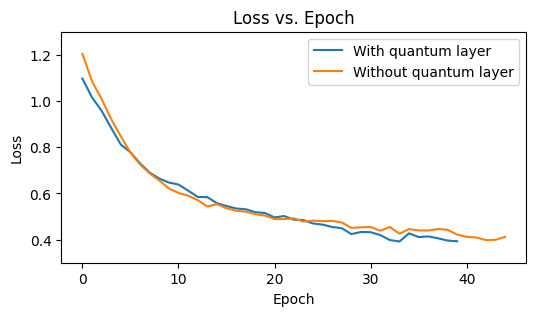

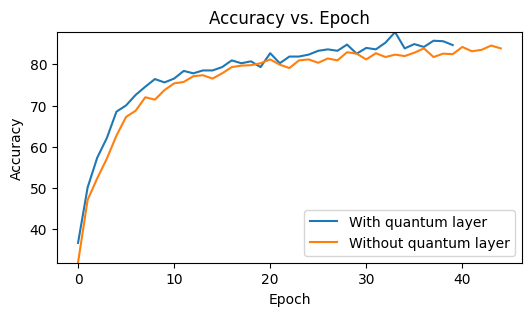

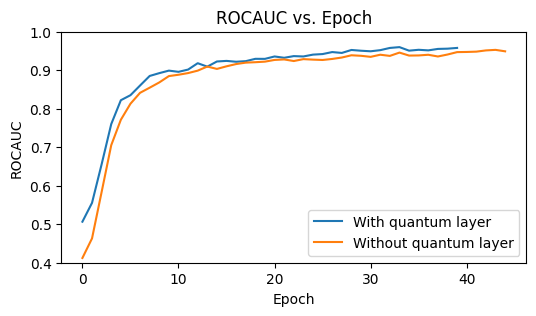

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

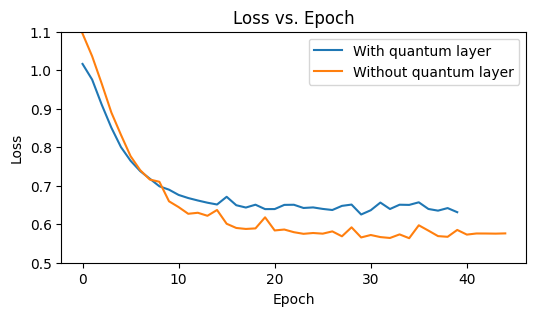

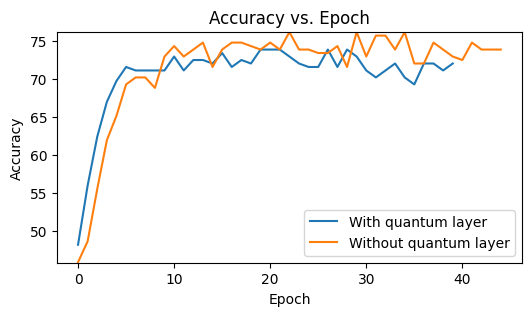

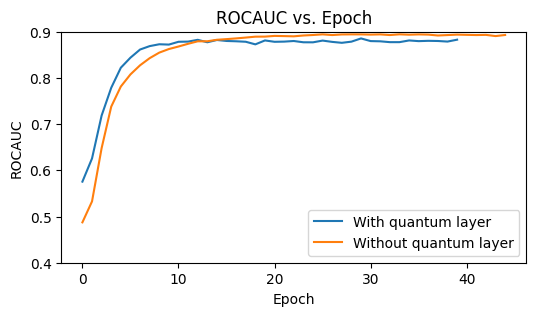

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

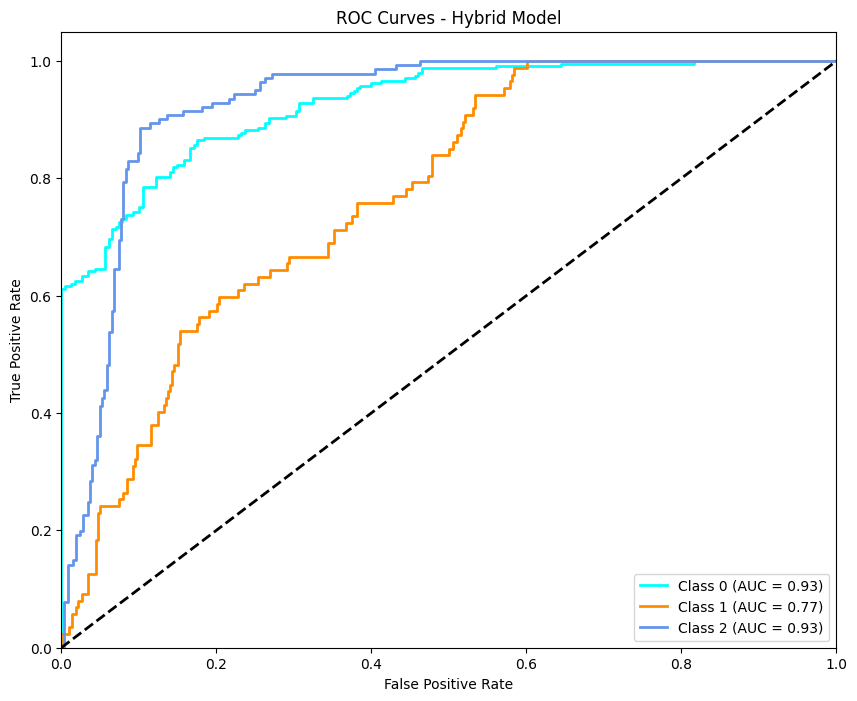

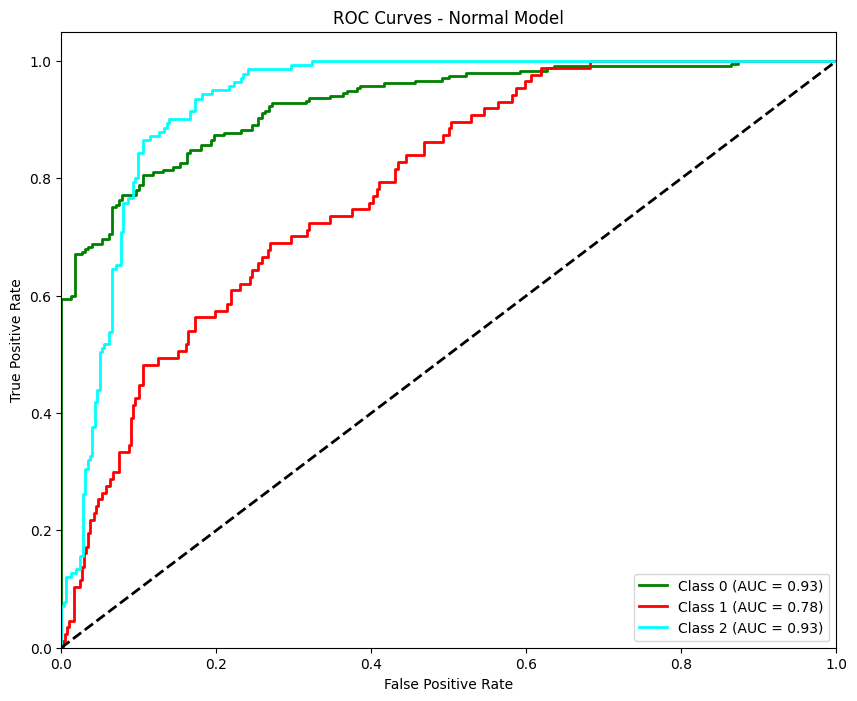


Hybrid Model Metrics:
Accuracy: 0.7462
F1 Score: 0.7332
Precision: 0.7257
Recall: 0.7462
AUROC: 0.8744

Normal Model Metrics:
Accuracy: 0.7677
F1 Score: 0.7655
Precision: 0.7677
Recall: 0.7677
AUROC: 0.8816 



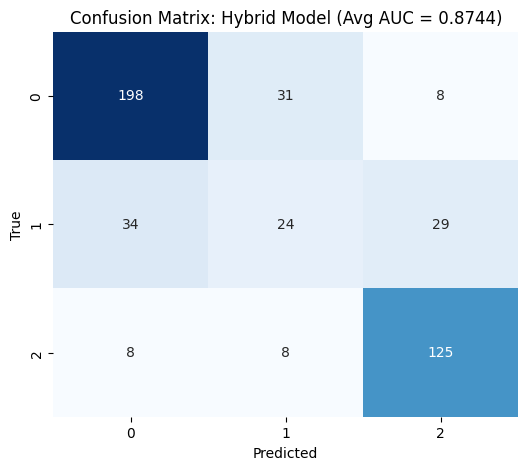

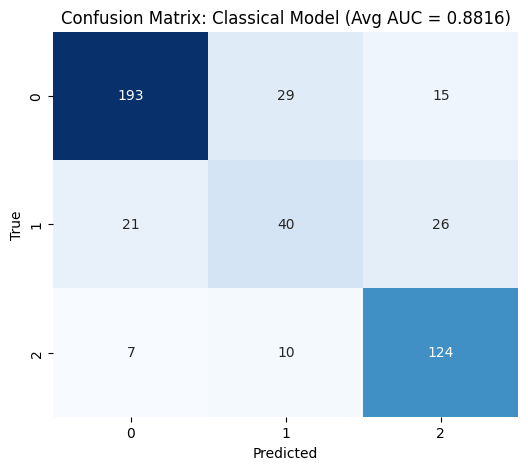

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

# Seed Experiment 5

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=3)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 82:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0324, Training Accuracy: 48.90%, Training AUROC: 0.5633
Validation Loss: 1.0270, Validation Accuracy: 50.00%, Validation AUROC: 0.5627
Epoch [2/100]
Training Loss: 0.9685, Training Accuracy: 53.08%, Training AUROC: 0.6411
Validation Loss: 0.9889, Validation Accuracy: 53.21%, Validation AUROC: 0.6072
Epoch [3/100]
Training Loss: 0.9141, Training Accuracy: 58.65%, Training AUROC: 0.7118
Validation Loss: 0.9291, Validation Accuracy: 57.34%, Validation AUROC: 0.6803
Epoch [4/100]
Training Loss: 0.8417, Training Accuracy: 64.00%, Training AUROC: 0.7765
Validation Loss: 0.8705, Validation Accuracy: 62.39%, Validation AUROC: 0.7362
Epoch [5/100]
Training Loss: 0.7752, Training Accuracy: 66.32%, Training AUROC: 0.8210
Validation Loss: 0.8276, Validation Accuracy: 64.22%, Validation AUROC: 0.7701
Epoch [6/100]
Training Loss: 0.7326, Training Accuracy: 69.45%, Training AUROC: 0.8393
Validation Loss: 0.7764, Validation Accuracy: 64.68%, Validation AUROC: 0.7978
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.1646, Training Accuracy: 29.50%, Training AUROC: 0.4429
Validation Loss: 1.1114, Validation Accuracy: 29.82%, Validation AUROC: 0.4658
Epoch [2/100]
Training Loss: 1.0795, Training Accuracy: 38.68%, Training AUROC: 0.4746
Validation Loss: 1.0500, Validation Accuracy: 48.62%, Validation AUROC: 0.5322
Epoch [3/100]
Training Loss: 1.0437, Training Accuracy: 49.01%, Training AUROC: 0.5483
Validation Loss: 1.0233, Validation Accuracy: 54.59%, Validation AUROC: 0.6134
Epoch [4/100]
Training Loss: 1.0153, Training Accuracy: 57.14%, Training AUROC: 0.6432
Validation Loss: 0.9975, Validation Accuracy: 59.63%, Validation AUROC: 0.6918
Epoch [5/100]
Training Loss: 0.9895, Training Accuracy: 62.49%, Training AUROC: 0.6877
Validation Loss: 0.9660, Validation Accuracy: 67.89%, Validation AUROC: 0.7283
Epoch [6/100]
Training Loss: 0.9576, Training Accuracy: 66.90%, Training AUROC: 0.7283
Validation Loss: 0.9386, Validation Accuracy: 68.35%, Validation AUROC: 0.7450
Epoc

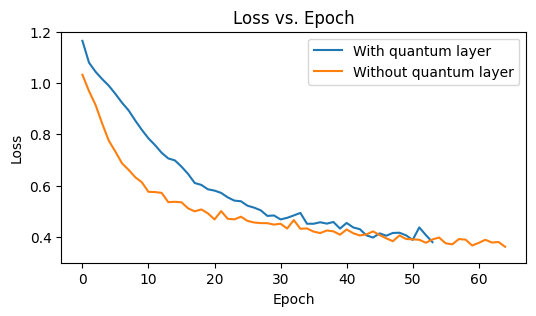

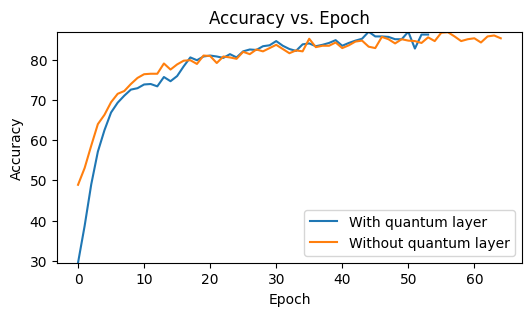

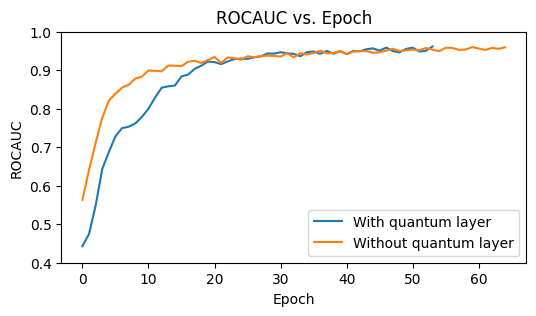

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

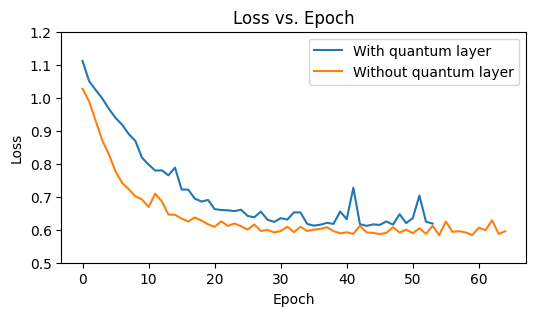

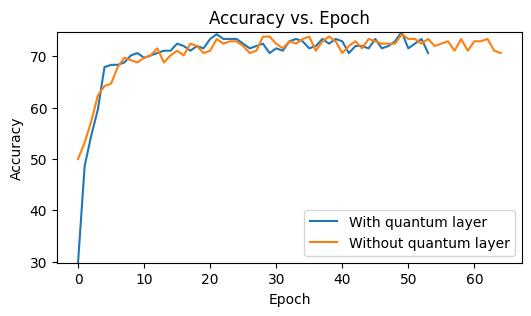

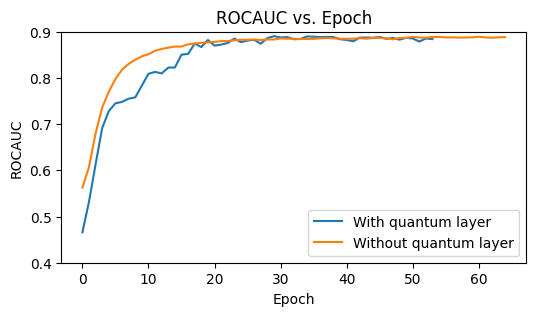

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

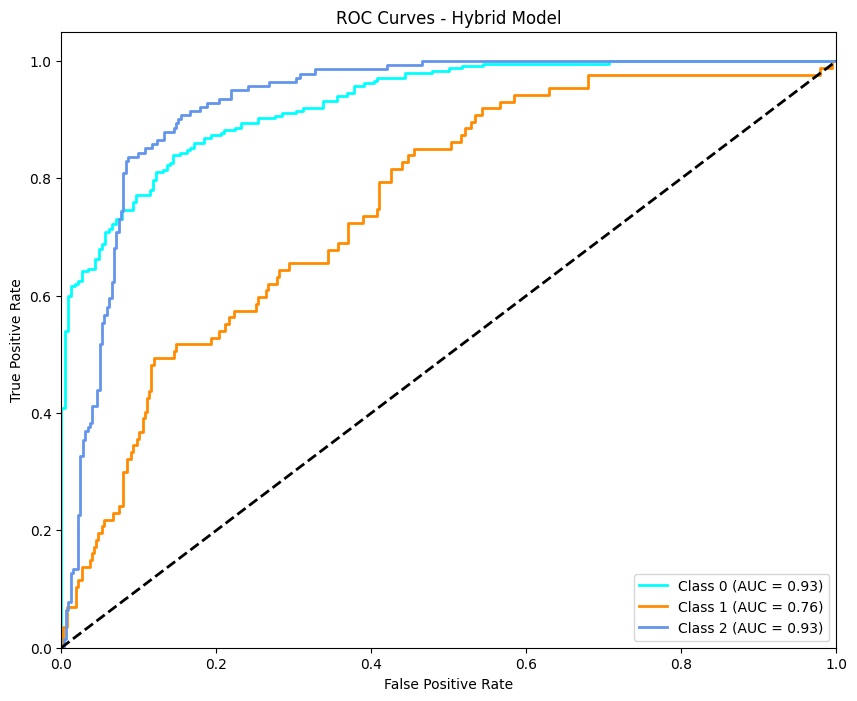

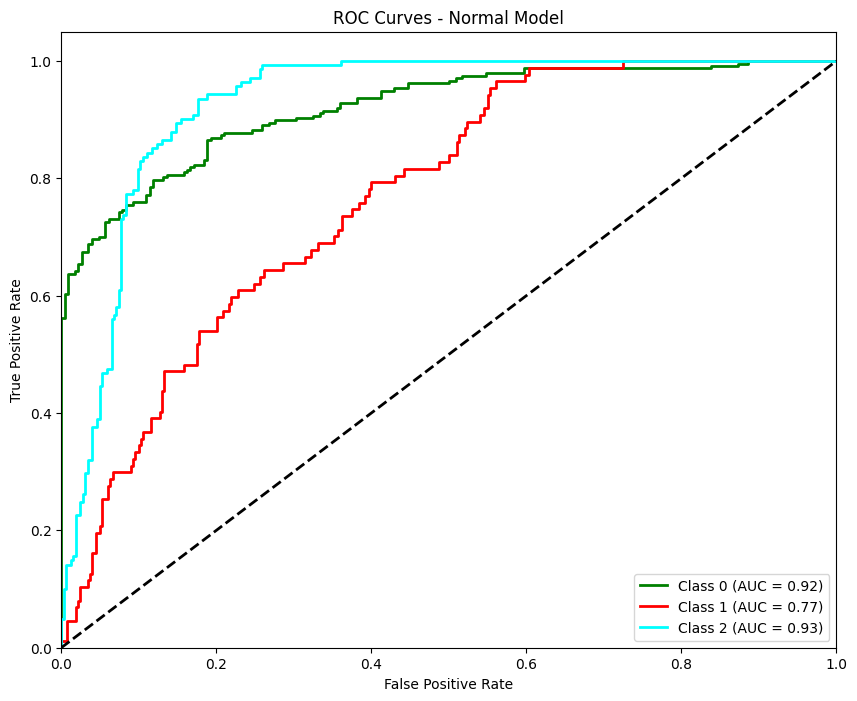


Hybrid Model Metrics:
Accuracy: 0.7548
F1 Score: 0.7517
Precision: 0.7500
Recall: 0.7548
AUROC: 0.8723

Normal Model Metrics:
Accuracy: 0.7376
F1 Score: 0.7398
Precision: 0.7438
Recall: 0.7376
AUROC: 0.8729 



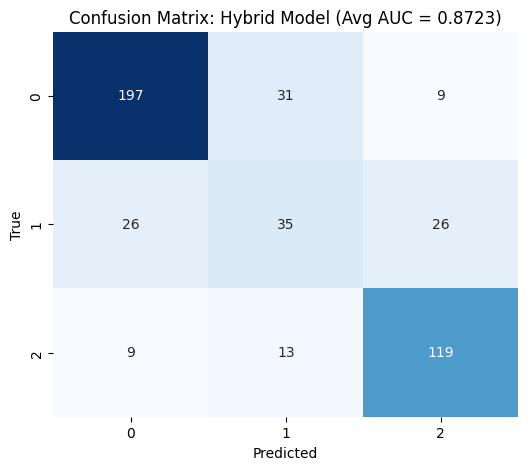

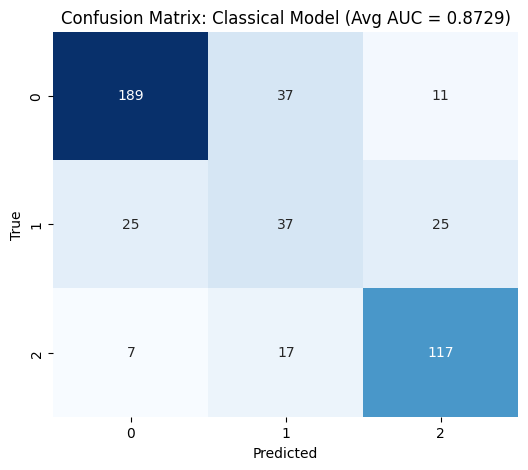

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)